## Import de librerias

In [1]:
!pip install -U scikit-learn
!pip install langdetect
!polyglot download embeddings2.en ner2.en embeddings2.es ner2.es

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=b5ca2b4c31e7e819ccec1fa037a47647911df6713ac7ecedb931d025d1dc240b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
/bin/bash: polyglot: command not found


In [2]:
import pandas as pd
import nltk
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
import xgboost as xgb


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from langdetect import detect





In [3]:
import joblib
import os.path
from google.colab import drive
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Montar Google Drive en Colab
drive.mount('/content/drive')

# Ruta del archivo de modelo
ruta_archivo = "/content/drive/MyDrive/TP2/modelos/"
#ruta_archivo = "/content/drive/MyDrive/Orga-de-Datos/TP2/modelos/"

# Train:
# https://drive.google.com/file/d/1M4BKi52TVBOnrBP8XpUwSlnlx0oX_K-D/view?usp=sharing
# Test:
# https://drive.google.com/file/d/1XYG0LEFd3bxysnwpM13MgIII-C4oozTV/view?usp=sharing

#dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1M4BKi52TVBOnrBP8XpUwSlnlx0oX_K-D")
#dataset.shape

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [4]:
#dataset.head()

Armamos una función de metricas para no tener que replicar el código en cada uno de los modelos que vamos a utilizar

In [5]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

## Preprocesamiento

Antes de entrenar los modelos, hacemos un pre procesamiento de nuestro dataset donde removemos palabras que son irrelevantes en el contexto de predecir si una crítica es positiva o no. Además reemplazamos las vocales de las palabras acentuadas por las que no tienen acento

In [8]:
def tolower(dataset):
    for i, review in enumerate(dataset['review_es']):
        palabras = review.split()
        palabras_min = [palabra.lower() for palabra in palabras]
        dataset.at[i, 'review_es'] = ' '.join(palabras_min)

Finalmente, aplicamos el proceso de tokenizado y volcamos nuevamente los valores en nuestra columna original

In [9]:
acentuadas_sin_acento = {
    'á': 'a',
    'é': 'e',
    'í': 'i',
    'ó': 'o',
    'ú': 'u',
    'Á': 'A',
    'É': 'E',
    'Í': 'I',
    'Ó': 'O',
    'Ú': 'U'
}

def remove_tildes(dataset):
  dataset['review_es'] = dataset['review_es'].apply(lambda x: ''.join([acentuadas_sin_acento.get(c, c) for c in x]))


In [10]:
def remove_stop_words(dataset):
  stop_words = set(stopwords.words('spanish'))
  dataset['review_es'] = dataset['review_es'].apply(lambda x: ' '.join([word for word in word_tokenize(x, language='spanish') if word.lower() not in stop_words]))


In [11]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'


def extract_spanish_reviews(dataset):
  dataset['language'] = dataset['review_es'].apply(detect_language)
  print(dataset.language.value_counts())
  print('Ejemplos de reviews en inglés a eliminar')
  print(dataset[dataset['language'] == 'en'])
  dataset.drop(dataset[dataset['language'] != 'es'].index, inplace=True)
  dataset.reset_index(drop=True, inplace=True)
  dataset.drop('language', axis=1, inplace=True)


In [12]:
def remove_punctuation(dataset):
  dataset['review_es'] = dataset['review_es'].apply(lambda x: x.replace('.', '. ') if '.' in x else x)
  dataset['review_es'] = dataset['review_es'].str.replace('[{}]'.format(string.punctuation), '')


In [13]:
def lemmatize_words(dataset):
  # Inicializar el lematizador
  lemmatizer = WordNetLemmatizer()

  # Normalizar las reseñas
  dataset['review_es'] = dataset['review_es'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x.lower(), language='spanish')]))


In [14]:
def remove_special_characters(dataset):
  # Tokenización y filtrado de caracteres
  patron = re.compile(r"[\W_]+", re.UNICODE)
  dataset['tokens'] = dataset['review_es'].apply(lambda x: [palabra for palabra in word_tokenize(x, language='spanish') if not patron.match(palabra)])
  dataset['review_es'] = dataset['tokens'].apply(lambda x: ' '.join(x))

In [15]:
def preprocesamiento_dataset(dataset, remove_SW, remove_not_spanish_reviews):
  if remove_not_spanish_reviews:
    extract_spanish_reviews(dataset)
  if remove_SW:
    remove_stop_words(dataset)
  remove_tildes(dataset)
  remove_punctuation(dataset)
  lemmatize_words(dataset)
  tolower(dataset)
  remove_special_characters(dataset)


Importamos y preprocesamos dataset de entrenamiento

In [16]:
try:
  # Este es el dataset preprocesado
  # https://drive.google.com/file/d/14dWGkgKr4XxU5P8ECXx6c6IuVgE-0UY5/view?usp=sharing
  dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=14dWGkgKr4XxU5P8ECXx6c6IuVgE-0UY5")
  # dataset = pd.read_csv('DS_train_filtrado.csv') # subiendolo a mano a colab pero también fallo
except Exception as e:
  # si no existe lo catcheamos acá y lo preprocesamos de nuevo
  dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1M4BKi52TVBOnrBP8XpUwSlnlx0oX_K-D")
  preprocesamiento_dataset(dataset, True, True)
  print("Se ha producido un error:", e)

Importamos y preprocesamos dataset de test

In [17]:
ds_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1XYG0LEFd3bxysnwpM13MgIII-C4oozTV")

# no eliminamos ninguna reseña así esté en otro idioma porque sí o sí la tenemos que predecir
preprocesamiento_dataset(ds_test, True, False)

<ipython-input-12-1c096f46f4f1>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['review_es'] = dataset['review_es'].str.replace('[{}]'.format(string.punctuation), '')


In [18]:
dataset

,ID,review_es,sentimiento
0,0,criticos mencionado despues ver solo 1 oz epis...,positivo
1,1,pequeña pequeña produccion la tecnica filmacio...,positivo
2,2,pense manera maravillosa pasar tiempo fin sema...,positivo
3,3,basicamente familia niño pequeño jake piensa z...,negativo
4,4,amor tiempo petter mattei pelicula visualmente...,positivo
...,...,...,...
48177,49995,pense pelicula hizo buen trabajo derecha no ta...,positivo
48178,49996,mala parcela mal dialogo mala actuacion direcc...,negativo
48179,49997,catolica enseñada escuelas primarias parroquia...,negativo
48180,49998,voy tener desacuerdo comentario anterior lado ...,negativo


In [19]:
ds_test

,ID,review_es,tokens
0,60000,mayor virtud pelicula existencia el hecho poda...,"[mayor, virtud, pelicula, existencia, el, hech..."
1,60001,experto cinefilo pocas veces habia tan juego s...,"[experto, cinefilo, pocas, veces, habia, tan, ..."
2,60002,si incondicional humor estilo tele 5 si termin...,"[si, incondicional, humor, estilo, tele, 5, si..."
3,60003,pasando si gente deja llevar modas si verdad g...,"[pasando, si, gente, deja, llevar, modas, si, ..."
4,60004,amanece quedo solo siento fondoun mar vacio se...,"[amanece, quedo, solo, siento, fondoun, mar, v..."
...,...,...,...
8594,68594,buena siguiente fin film serio interpretacion ...,"[buena, siguiente, fin, film, serio, interpret..."
8595,68595,esperaba ma guion visto novedoso absoluto prev...,"[esperaba, ma, guion, visto, novedoso, absolut..."
8596,68596,mal cuerpo sensacion finalizar historia intere...,"[mal, cuerpo, sensacion, finalizar, historia, ..."
8597,68597,añadido comentarios dicho claro guion pesimo a...,"[añadido, comentarios, dicho, claro, guion, pe..."


Fit y transform del CountVectorizer

In [20]:
# Train
X = dataset['review_es']
y = dataset['sentimiento']
y = y.replace({'positivo': 1, 'negativo': 0})
# Crear una instancia de CountVectorizer para convertir el texto en características numéricas
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# test
X_test_final = ds_test['review_es']
X_test_final = vectorizer.transform(X_test_final)

In [21]:
len(vectorizer.vocabulary_)

153273

### Función para hacer submit de los modelos

In [22]:
# nameCsv: null no exporta el csv
def createSubmitOfModel(model, nameCsv=None):
  model.fit(X,y)
  y_pred = model.predict(X_test_final)
  y_pred = ['positivo' if pred == 1 else 'negativo' for pred in y_pred]
  dataset_submit = pd.DataFrame({'ID': ds_test.ID, 'sentimiento': y_pred})
  if nameCsv is not None:
    dataset_submit.to_csv(f'{nameCsv}.csv',index=False)


### Función para hacer guardado de los modelos

In [59]:
def saveModels(models):
  for name in models:
    joblib.dump(models[name], ruta_archivo + name + '.joblib')

## Redes neuronales

### RNN

Definimos los parámetros que vamos a utilizar en los modelos de RNN y de RNN bidireccional.

`Observación:` Durante las pruebas, utilizamos los valores detallados abajo pero vimos que durante la epoca 4 ya teníamos el accuracy en 0,99 por lo que decidimos ajustar dichos valores y agregar una capa de regularización.

```
  max_len = 200
  embedding_dim = 128
  lstm_units = 64
  batch_size = 32
  epochs = 5
```

Luego, ajustando los valores del `batch_size` desde 32 a 128 pudimos reducir los tiempos de entrenamiento de 1hr 20 min a 15 min.

In [73]:
tokenized_reviews = dataset['review_es']
all_texts = np.concatenate([dataset['review_es'], ds_test['review_es']])
labels = dataset['sentimiento']

# Configuración de parámetros
max_len = 100
embedding_dim = 128
lstm_units = 32
batch_size = 128
epochs = 3

# Crear un tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

sequences = tokenizer.texts_to_sequences(tokenized_reviews)

padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Convertir las etiquetas a valores numéricos para entrenar el modelo
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# División en conjuntos de entrenamiento y prueba
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
# Construcción del modelo de RNN
rnn = Sequential()
rnn.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
rnn.add(LSTM(lstm_units))
rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
rnn.fit(x_train_rnn, y_train_rnn, batch_size=batch_size, epochs=epochs)

Epoch 1/3
302/302 [==============================] - 120s 388ms/step - loss: 0.3818 - accuracy: 0.8282
Epoch 2/3
302/302 [==============================] - 108s 358ms/step - loss: 0.1448 - accuracy: 0.9494
Epoch 3/3
302/302 [==============================] - 108s 359ms/step - loss: 0.0556 - accuracy: 0.9828


302/302 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4837
           1       0.85      0.87      0.86      4799

    accuracy                           0.86      9636
   macro avg       0.86      0.86      0.86      9636
weighted avg       0.86      0.86      0.86      9636



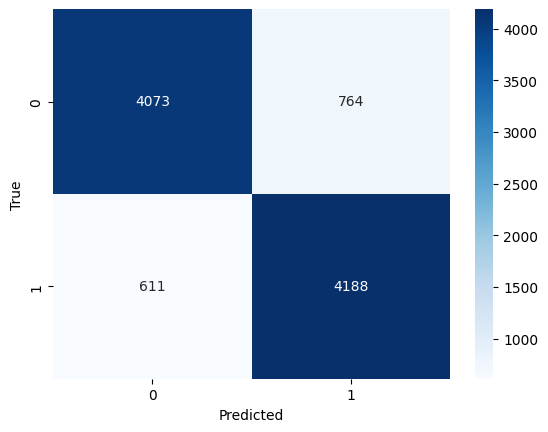

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = rnn.predict(x_test_rnn)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

metricas(np.array(predicted_labels), y_test_rnn)

In [58]:
Y_train = dataset['sentimiento']
X_test = ds_test['review_es']

test_tokenized_reviews = tokenizer.texts_to_sequences(ds_test['review_es'])

max_len = max(max(len(seq) for seq in sequences), max(len(seq) for seq in test_tokenized_reviews))

test_padded_sequences = pad_sequences(test_tokenized_reviews, maxlen=max_len)

padded_sequences = pad_sequences(sequences, maxlen=max_len)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y_train)

# Construcción del modelo de RNN
rnn_final = Sequential()
rnn_final.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
rnn_final.add(LSTM(lstm_units))
rnn_final.add(Dropout(0.1))
rnn_final.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
rnn_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo con dataset completo
rnn_final.fit(padded_sequences, encoded_labels, batch_size=batch_size, epochs=epochs)

Epoch 1/3
377/377 [==============================] - 531s 1s/step - loss: 0.3622 - accuracy: 0.8388
Epoch 2/3
377/377 [==============================] - 525s 1s/step - loss: 0.1409 - accuracy: 0.9521
Epoch 3/3
377/377 [==============================] - 525s 1s/step - loss: 0.0613 - accuracy: 0.9809


In [60]:
# Realizar predicciones en el dataset de prueba
y_pred_final = rnn_final.predict(test_padded_sequences)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = ['positivo' if p >= 0.5 else 'negativo' for p in y_pred_final]

print(predicted_labels)

269/269 [==============================] - 19s 71ms/step
['negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'negat

In [61]:
dataset_submit = pd.DataFrame({'ID': ds_test.ID, 'sentimiento': predicted_labels})
dataset_submit.to_csv('predict_rnn_token.csv',index=False)

In [62]:
# Save model
# guardo modelo
modelos = {'RNN_model': rnn_final}

saveModels(modelos)

### RNN bidireccional

Como segundo approach, encontramos que podemos mejorar la prediccion agregando una capa bidireccional al modelo.


Las redes neuronales recurrentes bidireccionales (RNN) en realidad solo están juntando dos RNN independientes. La secuencia de entrada se alimenta en orden de tiempo normal para una red y en orden de tiempo inverso para otra. Las salidas de las dos redes generalmente se concatenan en cada paso de tiempo.

Esta estructura permite que las redes tengan información hacia adelante y hacia atrás sobre la secuencia en cada paso de tiempo.

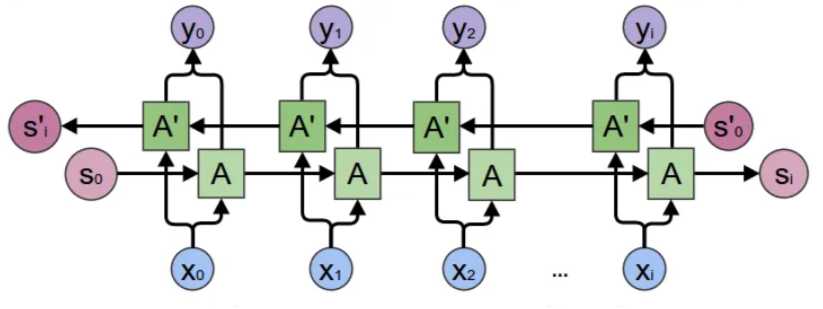

Sin embargo, cuando realizamos la predicción en kaggle vimos que no fue asi ya que obtuvimos un f1-score menor que el modelo de RNN original.

In [ ]:
# División en conjuntos de entrenamiento y prueba
x_train_rnn_bi, x_test_rnn_bi, y_train_rnn_bi, y_test_rnn_bi = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Construcción del modelo de RNN bidireccional
rnn_bi = Sequential()
rnn_bi.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
rnn_bi.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
rnn_bi.add(Dropout(0.1))
rnn_bi.add(Bidirectional(LSTM(lstm_units)))
rnn_bi.add(Dropout(0.1))
rnn_bi.add(Dense(64, activation='relu'))
rnn_bi.add(Dropout(0.1))
rnn_bi.add(Dense(1, activation='sigmoid'))

# Compilación del modelo con capa bidireccional
rnn_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo con capa bidireccional
rnn_bi.fit(x_train_rnn_bi, y_train_rnn_bi, batch_size=batch_size, epochs=3)

Epoch 1/3
302/302 [==============================] - 145s 458ms/step - loss: 0.3676 - accuracy: 0.8307
Epoch 2/3
302/302 [==============================] - 136s 452ms/step - loss: 0.1238 - accuracy: 0.9559
Epoch 3/3
302/302 [==============================] - 156s 516ms/step - loss: 0.0387 - accuracy: 0.9880


313/313 [==============================] - 11s 31ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4961
           1       0.87      0.80      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



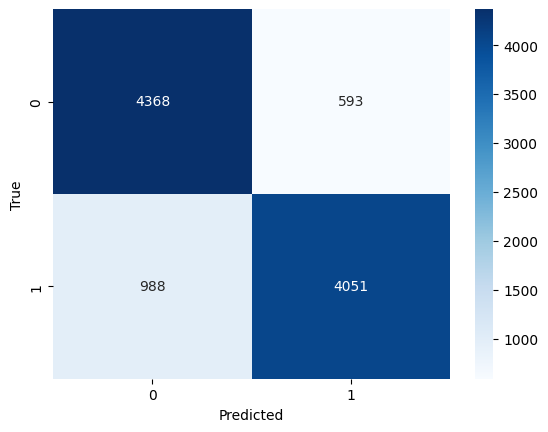

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = rnn_bi.predict(x_test_rnn_bi)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

metricas(np.array(predicted_labels), y_test_rnn_bi)

In [63]:
# Construcción del modelo de RNN
rnn_bi_final = Sequential()
rnn_bi_final.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
rnn_bi_final.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
rnn_bi_final.add(Dropout(0.1))
rnn_bi_final.add(Bidirectional(LSTM(lstm_units)))
rnn_bi_final.add(Dropout(0.1))
rnn_bi_final.add(Dense(64, activation='relu'))
rnn_bi_final.add(Dropout(0.1))
rnn_bi_final.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
rnn_bi_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
rnn_bi_final.fit(padded_sequences, encoded_labels, batch_size=batch_size, epochs=epochs)

Epoch 1/3
377/377 [==============================] - 1216s 3s/step - loss: 0.3480 - accuracy: 0.8461
Epoch 2/3
377/377 [==============================] - 1218s 3s/step - loss: 0.1173 - accuracy: 0.9589
Epoch 3/3
377/377 [==============================] - 1223s 3s/step - loss: 0.0469 - accuracy: 0.9856


In [64]:
test_tokenized_reviews = tokenizer.texts_to_sequences(ds_test['review_es'])
test_padded_sequences = pad_sequences(test_tokenized_reviews, maxlen=max_len)

# Realizar predicciones en el dataset de prueba
y_pred_final = rnn_bi_final.predict(test_padded_sequences)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = ['positivo' if p >= 0.5 else 'negativo' for p in y_pred_final]

print(predicted_labels)

269/269 [==============================] - 65s 235ms/step
['negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'nega

In [65]:
dataset_submit = pd.DataFrame({'ID': ds_test.ID, 'sentimiento': predicted_labels})
dataset_submit.to_csv('predict_rnn_bidireccional_3.csv',index=False)

In [66]:
# Save model
# guardo modelo
modelos = {'RNN_BI_model': rnn_bi_final}

saveModels(modelos)

### CNN

In [ ]:
# Configuración de parámetros
max_len = 100
embedding_dim = 128
num_filters = 128
filter_size = 5

# División en conjuntos de entrenamiento y prueba (80/20)
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Construcción del modelo de CNN
cnn = Sequential()
cnn.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
cnn.add(Conv1D(num_filters, filter_size, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
cnn.fit(x_train_cnn, y_train_cnn, batch_size=batch_size, epochs=epochs)

Epoch 1/5
1205/1205 [==============================] - 873s 723ms/step - loss: 0.3914 - accuracy: 0.8200
Epoch 2/5
1205/1205 [==============================] - 856s 710ms/step - loss: 0.1536 - accuracy: 0.9440
Epoch 3/5
1205/1205 [==============================] - 875s 725ms/step - loss: 0.0257 - accuracy: 0.9946
Epoch 4/5
1205/1205 [==============================] - 810s 672ms/step - loss: 0.0026 - accuracy: 0.9998
Epoch 5/5
1205/1205 [==============================] - 806s 669ms/step - loss: 4.0323e-04 - accuracy: 1.0000


302/302 [==============================] - 7s 22ms/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.84      4855
           1       0.82      0.88      0.85      4782

    accuracy                           0.84      9637
   macro avg       0.84      0.84      0.84      9637
weighted avg       0.84      0.84      0.84      9637



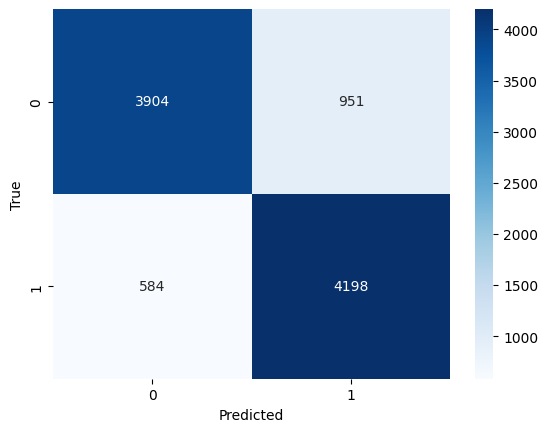

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = rnn.predict(x_test_cnn)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

metricas(np.array(predicted_labels), y_test_cnn)

In [74]:
# Configuración de parámetros
embedding_dim = 128
num_filters = 128
filter_size = 5

test_tokenized_reviews = tokenizer.texts_to_sequences(ds_test['review_es'])
test_padded_sequences = pad_sequences(test_tokenized_reviews, maxlen=max_len)

# Construcción del modelo de CNN
cnn_final = Sequential()
cnn_final.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_len))
cnn_final.add(Conv1D(num_filters, filter_size, activation='relu'))
cnn_final.add(Dropout(0.5))
cnn_final.add(GlobalMaxPooling1D())
cnn_final.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
cnn_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
cnn_final.fit(padded_sequences, encoded_labels, batch_size=batch_size, epochs=epochs)

Epoch 1/3
1506/1506 [==============================] - 1214s 805ms/step - loss: 0.3678 - accuracy: 0.8301
Epoch 2/3
1506/1506 [==============================] - 1240s 823ms/step - loss: 0.1610 - accuracy: 0.9402
Epoch 3/3
1506/1506 [==============================] - 1256s 834ms/step - loss: 0.0406 - accuracy: 0.9887


In [75]:
# Realizar predicciones en el dataset de prueba
y_pred_final = cnn_final.predict(test_padded_sequences)

# Convertir las probabilidades en etiquetas de clase
predicted_labels = ['positivo' if p >= 0.5 else 'negativo' for p in y_pred_final]

print(predicted_labels)

269/269 [==============================] - 7s 26ms/step
['positivo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'negativo', 'negativo', 'positivo', 'positivo', 'negativo', 'positivo', 'positivo', 'positivo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negativo', 'negativo', 'positivo', 'negativo', 'negativo', 'positivo', 'positivo', 'positivo', 'positivo', 'positivo', 'negati

In [76]:
dataset_submit = pd.DataFrame({'ID': ds_test.ID, 'sentimiento': predicted_labels})
dataset_submit.to_csv('predict_cnn.csv',index=False)

In [77]:
# Save model
# guardo modelo
modelos = {'CNN_model': cnn_final}

saveModels(modelos)

## Bayes Naive

### Default

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear una instancia del clasificador Naive Bayes
bn = MultinomialNB()

# Entrenar el modelo Naive Bayes
bn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = bn.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7283
           1       0.86      0.85      0.85      7172

    accuracy                           0.86     14455
   macro avg       0.86      0.86      0.86     14455
weighted avg       0.86      0.86      0.86     14455



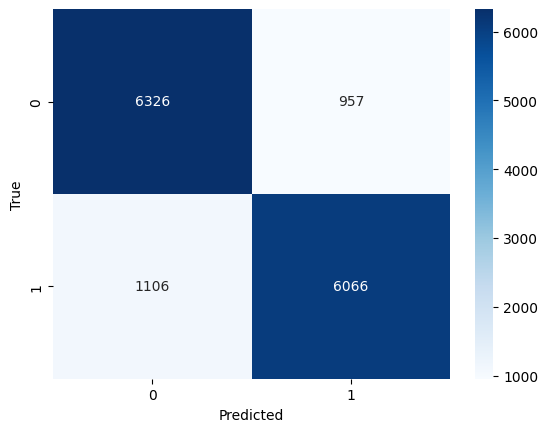

In [25]:
metricas(y_pred, y_test)

### CV

In [37]:
# Definir los hiperparámetros a ajustar y sus rangos de búsqueda
parametros = {
    'alpha': np.linspace(0.1, 1.0, num=10),  # Parámetro de suavizado de Laplace
    'fit_prior': [True, False],  # Aprender probabilidades a priori
}

bnCV = MultinomialNB()


# Definir el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bnCV, param_distributions=parametros, scoring=make_scorer(f1_score), cv=5, n_iter=10, random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
BN_best_params = random_search.best_params_

print(BN_best_params)
print(random_search.best_score_)

{'fit_prior': True, 'alpha': 1.0}
0.8542141168086514


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7432
           1       0.85      0.86      0.85      7023

    accuracy                           0.86     14455
   macro avg       0.86      0.86      0.86     14455
weighted avg       0.86      0.86      0.86     14455



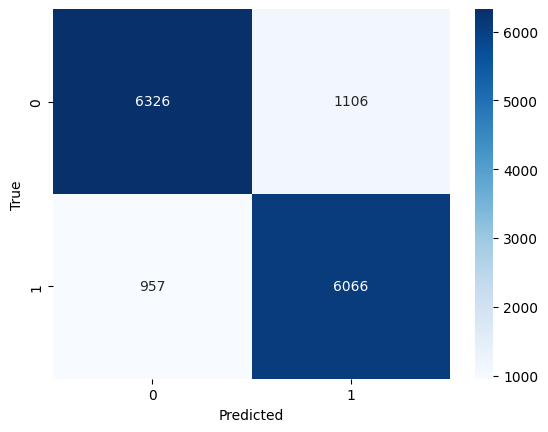

In [38]:
#Obtenemos el mejor modelo
bestEstimator=random_search.best_estimator_

#Predicción
yPredByBestEstimator = bestEstimator.predict(X_test)

metricas(y_test, yPredByBestEstimator)

### Submit y guardado de modelos

Submit

In [ ]:
nombreBNDefault = 'BNSubmitDefault'
nombreBNCV = 'BNSubmitCV'

BNSubmitDefault = MultinomialNB()
createSubmitOfModel(BNSubmitDefault, nombreBNDefault)

BNSubmitCV = MultinomialNB(**BN_best_params)
createSubmitOfModel(BNSubmitCV, nombreBNCV)

Guardado

In [ ]:
modelos = {nombreBNDefault: BNSubmitDefault, nombreBNCV: BNSubmitCV}

saveModels(modelos)

## Random Forest

### Default

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de RF
RFSubmitDefaultTrain = RandomForestClassifier()


# Entrenar el modelo
RFSubmitDefaultTrain.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = RFSubmitDefaultTrain.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo: %.2f%%" % (accuracy * 100.0))

Precisión del modelo: 84.71%


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7369
           1       0.84      0.85      0.84      7086

    accuracy                           0.85     14455
   macro avg       0.85      0.85      0.85     14455
weighted avg       0.85      0.85      0.85     14455



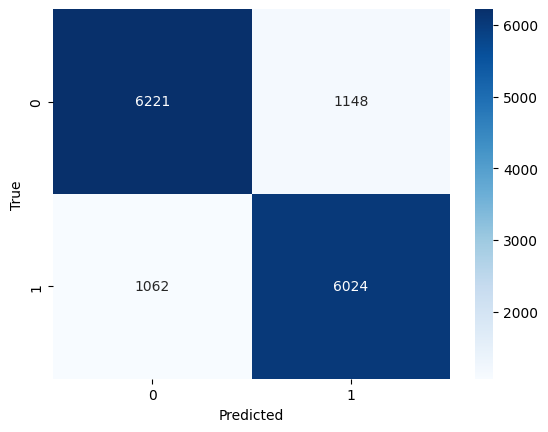

In [ ]:
metricas(y_test, y_pred)


### RF con hiperparametros optimizados

Preparo el set de datos para poder hacer un RandomSearchCV

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#
rfCV = RandomForestClassifier(max_features='sqrt', random_state=42, n_jobs=-1)

params_RF_Randomized = {'criterion':['gini','entropy'],
              'min_samples_leaf':list(range(1,5)),
              'min_samples_split': list(range(2,10)),
              'ccp_alpha': [0, 0.001, 0.01, 0,1],
              'max_depth':list(range(8,40)),
              'n_estimators': [50, 100, 150]
               }

# Definir el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfCV, param_distributions=params_RF_Randomized, scoring=make_scorer(f1_score), cv=5, n_iter=10, random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
RF_best_params = random_search.best_params_
print("Mejores hiperparámetros:", RF_best_params)


Mejores hiperparámetros: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}


In [ ]:
#Mejores hiperparámetros:
 #{'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}

print(random_search.best_score_)

0.8493734890429341


In [ ]:
#Obtenemos el mejor modelo
bestEstimator=random_search.best_estimator_

#Predicción
yPredByBestEstimator = bestEstimator.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      6862
           1       0.88      0.83      0.85      7593

    accuracy                           0.85     14455
   macro avg       0.85      0.85      0.85     14455
weighted avg       0.85      0.85      0.85     14455



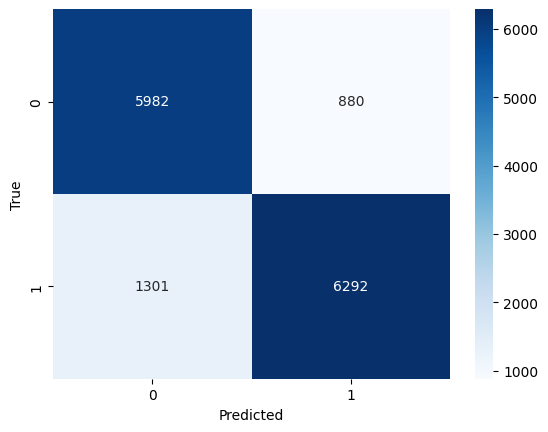

In [ ]:
metricas(y_test, yPredByBestEstimator)

### Submit y guardado de modelos

In [ ]:
#Submit
nombreRFDefault = 'RFSubmitDefault'
nombreRFCV = 'RFSubmitCV'

RFSubmitDefault = RandomForestClassifier()

createSubmitOfModel(RFSubmitDefault, nombreRFDefault)

RFSubmitCV = RandomForestClassifier(**RF_best_params)
createSubmitOfModel(RFSubmitCV, nombreRFCV)

In [ ]:
####Guardamos los modelos

modelos = {nombreRFDefault: RFSubmitDefault, nombreRFCV: RFSubmitCV}
saveModels(modelos)

## XGBoost


### Default

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de XGBoost
xgboostDefault = xgb.XGBClassifier(n_jobs=-1)

xgboostDefault.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#Predicción
final_y_pred = xgboostDefault.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      6963
           1       0.87      0.83      0.85      7492

    accuracy                           0.85     14455
   macro avg       0.85      0.85      0.85     14455
weighted avg       0.85      0.85      0.85     14455



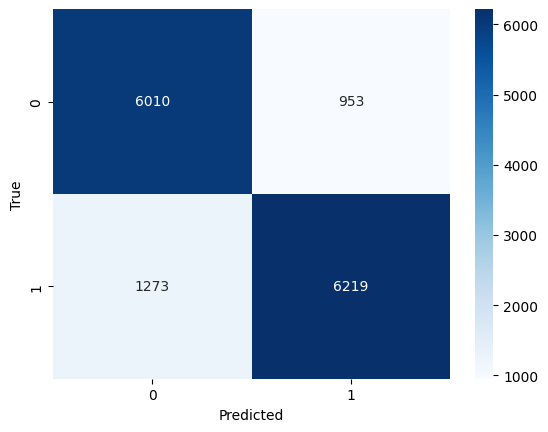

In [ ]:
metricas(y_test, final_y_pred)

### con CV

In [26]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de XGBoost
xgboostCV = xgb.XGBClassifier(n_jobs=-1)

# Definir los parámetros que se van a probar en la búsqueda aleatoria
params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

# Definir el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgboostCV, param_distributions=params, scoring=make_scorer(f1_score), cv=5, n_iter=10, random_state=42, n_jobs=-1)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
XGBoost_best_params = random_search.best_params_
print("Mejores hiperparámetros:", XGBoost_best_params)


Mejores hiperparámetros: {'reg_lambda': 0.0, 'reg_alpha': 0.0, 'min_child_weight': 3, 'max_depth': 7, 'gamma': 0.1}


In [27]:
print("f1 score en entrenamiento con cross validation: "+str(random_search.best_score_))

f1 score en entrenamiento con cross validation: 0.8488729706687848


In [28]:
#Obtenemos el mejor modelo
bestEstimator=random_search.best_estimator_

#Predicción
yPredByBestEstimator = bestEstimator.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      7034
           1       0.86      0.83      0.85      7421

    accuracy                           0.85     14455
   macro avg       0.85      0.85      0.85     14455
weighted avg       0.85      0.85      0.85     14455



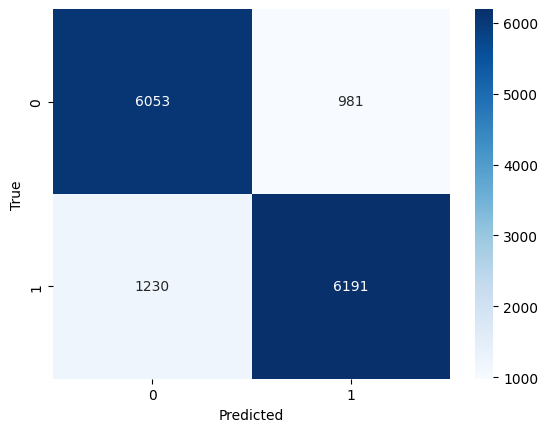

In [29]:
metricas(y_test, yPredByBestEstimator)

### Submit y guardado de modelos

In [49]:
#Submit
nombreXGBoostDefault = 'XGBoostSubmitDefault'
nombreXGBoostCV = 'XGBoostSubmitCV'

XGBoostSubmitDefault = xgb.XGBClassifier()

createSubmitOfModel(XGBoostSubmitDefault, nombreXGBoostDefault)

XGBoostSubmitCV = xgb.XGBClassifier(**XGBoost_best_params)
createSubmitOfModel(XGBoostSubmitCV, nombreXGBoostCV)


In [50]:
####Guardamos los modelos
modelos = {nombreXGBoostDefault: XGBoostSubmitDefault, nombreXGBoostCV: XGBoostSubmitCV}
saveModels(modelos)

## Ensambles Híbridos

#### Voting

##### Soft

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7283
           1       0.87      0.87      0.87      7172

    accuracy                           0.87     14455
   macro avg       0.87      0.87      0.87     14455
weighted avg       0.87      0.87      0.87     14455



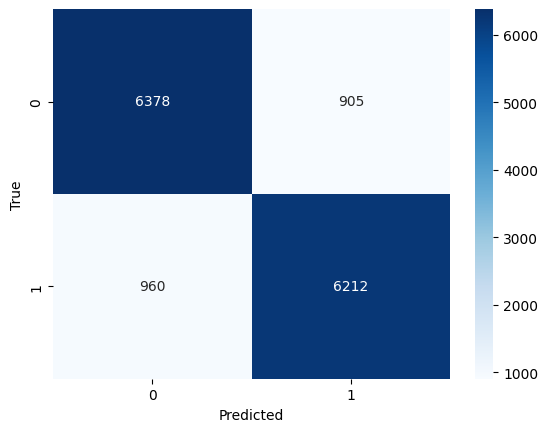

In [52]:
ensamble_voting_soft_nombre= "ensamble_voting_soft.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_soft_nombre):
  votingClasifSoftModel = joblib.load(ruta_archivo + ensamble_voting_soft_nombre)

else:
  #Modelos Base
  RF_params = {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}
  xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
  BN_params = {'fit_prior': False, 'alpha': 1.5};

  base_models = [('RF', RandomForestClassifier(**RF_params)),
                 ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                 ('BN', MultinomialNB(**BN_params))]

  #Ensamble híbrido tipo Voting
  votingClasifSoftModel = VotingClassifier(estimators = base_models, voting = 'soft', n_jobs=-1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  #Entreno el ensemble
  votingClasifSoftModel.fit(X_train, y_train)

#Evaluo en conjunto de test
yPredVoting = votingClasifSoftModel.predict(X_test)
metricas(yPredVoting, y_test)

Submit

In [39]:
ensamble_voting_soft_nombre= "ensamble_voting_soft.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_soft_nombre):
  votingClasifSoftModel = joblib.load(ruta_archivo + ensamble_voting_soft_nombre)

else:
  #Modelos Base
  RF_params = {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}
  xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
  BN_params = {'fit_prior': False, 'alpha': 1.5};

  base_models = [('RF', RandomForestClassifier(**RF_params)),
                 ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                 ('BN', MultinomialNB(**BN_params))]

  #Ensamble híbrido tipo Voting
  votingClasifSoftModel = VotingClassifier(estimators = base_models, voting = 'soft', n_jobs=-1)

  createSubmitOfModel(votingClasifSoftModel, 'ensamble_voting_soft')

#   #Entreno el ensemble
#   votingClasifSoftModel.fit(X, y)

# #Evaluo en conjunto de test
# yPredVoting = votingClasifSoftModel.predict(X_test_final)

In [41]:
# guardo modelo
modelos = {'ensamble_voting_soft': votingClasifSoftModel}

saveModels(modelos)

##### Hard

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      7283
           1       0.85      0.89      0.87      7172

    accuracy                           0.86     14455
   macro avg       0.87      0.87      0.86     14455
weighted avg       0.87      0.86      0.86     14455



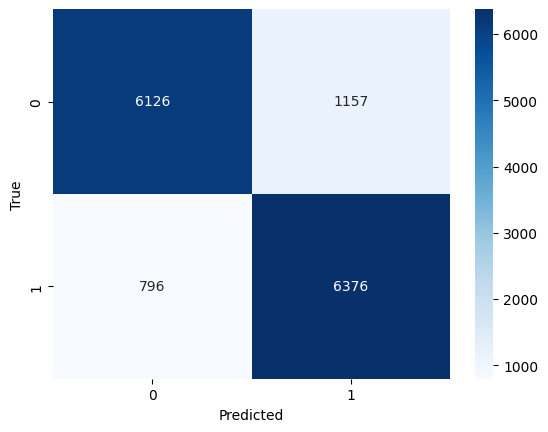

In [53]:
ensamble_voting_hard_nombre= "ensamble_voting_hard.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_hard_nombre):
  votingClasifHardModel = joblib.load(ruta_archivo + ensamble_voting_hard_nombre)

else:
  #Modelos Base
  RF_params = {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}
  xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
  BN_params = {'fit_prior': False, 'alpha': 1.5};

  base_models = [('RF', RandomForestClassifier(**RF_params)),
                 ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                 ('BN', MultinomialNB(**BN_params))]

  #Ensamble híbrido tipo Voting
  votingClasifHardModel = VotingClassifier(estimators = base_models, voting = 'hard', n_jobs=-1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  #Entreno el ensemble
  votingClasifHardModel.fit(X_train, y_train)

#Evaluo en conjunto de test
yPredVoting = votingClasifHardModel.predict(X_test)
metricas(yPredVoting, y_test)

submit

In [42]:
ensamble_voting_hard_nombre= "ensamble_voting_hard.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_hard_nombre):
  votingClasifHardModel = joblib.load(ruta_archivo + ensamble_voting_hard_nombre)

else:
  #Modelos Base
  RF_params = {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}
  xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
  BN_params = {'fit_prior': False, 'alpha': 1.5};

  base_models = [('RF', RandomForestClassifier(**RF_params)),
                 ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                 ('BN', MultinomialNB(**BN_params))]

  #Ensamble híbrido tipo Voting
  votingClasifHardModel = VotingClassifier(estimators = base_models, voting = 'hard', n_jobs=-1)

  createSubmitOfModel(votingClasifHardModel, 'votingClasifHardModel')

In [43]:
# guardo modelo
modelos = {'ensamble_voting_hard': votingClasifHardModel}

saveModels(modelos)

#### Stacking

In [54]:
ensamble_stacking_nombre= "ensamble_stacking.joblib"

if False & os.path.isfile(ruta_archivo + ensamble_stacking_nombre):
  stacking_model = joblib.load(ruta_archivo + ensamble_stacking_nombre)

else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  #Modelos Base
  xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
  BN_params = {'fit_prior': False, 'alpha': 1.5};
  base_models = [('RF', RandomForestClassifier()),
                 ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                 ('BN', MultinomialNB(**BN_params))]

  #Ensemble Stacking con final estimator default (LinearRegressionModel)
  stacking_model = StackingClassifier(estimators=base_models,
                                      #passthrough=True, esto tira error:  sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
                                      # final_estimator=meta_model,
                                      # cv=5,
                                      #verbose=2,
                                      n_jobs=-1)

  stacking_model.fit(X_train,y_train)


yPredStacking= stacking_model.predict(X_test)

#Evaluo en conjunto de test
metricas(yPredStacking, y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

Submit

In [45]:
#Modelos Base
RF_params = {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy', 'ccp_alpha': 0}
xgboost_params = {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.2};
BN_params = {'fit_prior': False, 'alpha': 1.5};

base_models = [('RF', RandomForestClassifier(**RF_params)),
                ('xgboost', xgb.XGBClassifier(**xgboost_params)),
                ('BN', MultinomialNB(**BN_params))]


#Ensemble Stacking con final estimator default (LinearRegressionModel)
stacking_modelSubmit = StackingClassifier(estimators=base_models,
                                    #passthrough=True, esto tira error:  sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1)
                                    #verbose=2,
                                    n_jobs=-1)

createSubmitOfModel(stacking_modelSubmit, 'stacking_modelSubmit')

# #predict
# y_pred_stacking = stacking_modelSubmit.predict(X_test_final)

# # parse
# y_pred_stacking = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_stacking]

# #csv
# dataset_submit_stacking = pd.DataFrame({'ID': ds_test.ID, 'sentimiento': y_pred_stacking})
# dataset_submit_stacking.to_csv('stacking_modelSubmit.csv',index=False)

In [47]:
modelos = {'stacking_modelSubmit': stacking_modelSubmit}
saveModels(modelos)